<h1>Assignment 20</h1>

### This Assignment contains some code blocks took from original ipython notebooks (`4.ML_models.ipynb` and other notebooks).

**I am using following files that are created from other ipython notebooks to run the models.**
- `train.csv`
- `nlp_features_train.csv`
- `df_fe_without_preprocessing_train.csv`
- `train.db`

In [2]:
# Required Imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
import datetime as dt
import numpy as np

from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Task 1

### Train Logistic Regression and Linear-SVM with TfIdf vectorization of questions data.
**Taking only first 50,000 rows to train and test the data due to computation limitations.**

In [3]:
main_data = pd.read_csv('train.csv', nrows=50000)
main_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
nlp_feats = pd.read_csv('nlp_features_train.csv', nrows=50000, encoding='latin-1')
nlp_feats.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [5]:
feat_engg = pd.read_csv('df_fe_without_preprocessing_train.csv', nrows=50000, encoding='latin-1')
feat_engg.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


**Splitting data into train and test data before applying TfIdf vectorizer to avoid data leakage**

In [6]:
questions = main_data[['question1', 'question2']]
labels = pd.DataFrame(main_data['is_duplicate'])
questions.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [0]:
q_train, q_test, labels_train, labels_test = train_test_split(questions, labels, test_size=0.2)

In [0]:
train_ind = q_train.index
test_ind = q_test.index

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
quest_to_vectorize = list(q_train['question1']) + list(q_train['question2'])
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf.fit(quest_to_vectorize)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [10]:
q1_train = tfidf.transform(q_train['question1'].values)
q2_train = tfidf.transform(q_train['question2'].values)
q1_test = tfidf.transform(q_test['question1'].values)
q2_test = tfidf.transform(q_test['question2'].values)

print(q1_train.shape)
print(q2_train.shape)
print(q1_test.shape)
print(q1_test.shape)

(40000, 5000)
(40000, 5000)
(10000, 5000)
(10000, 5000)


**Splitting all DataFrames according to `train_ind` and `test_ind` obtained from train_test_split and combine them to form X_train and X_test** 

In [11]:
feat_engg.drop(columns=main_data.columns, inplace=True)
nlp_feats.drop(columns=main_data.columns, inplace=True)
print(feat_engg.shape)
print(nlp_feats.shape)

(50000, 11)
(50000, 15)


In [12]:
feat_engg_train = feat_engg.loc[train_ind, :]
feat_engg_test = feat_engg.loc[test_ind, :]
nlp_feats_train = nlp_feats.loc[train_ind, :]
nlp_feats_test = nlp_feats.loc[test_ind, :]

print(feat_engg_train.shape)
print(feat_engg_test.shape)
print(nlp_feats_train.shape)
print(nlp_feats_test.shape)

(40000, 11)
(10000, 11)
(40000, 15)
(10000, 15)


In [13]:
X_train = hstack((feat_engg_train, nlp_feats_train, q1_train, q2_train)).tocsr()
X_test = hstack((feat_engg_test, nlp_feats_test, q1_test, q2_test)).tocsr()
y_train = labels_train
y_test = labels_test

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 10026) (40000, 1)
(10000, 10026) (10000, 1)


**As our data is ready we perform Logistic Regression and Linear-SVM on the data. For this I will take the code from one of the original ipython notebooks**

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Training a Random model to know worst-log-loss that we can get.

Log loss on Test Data using Random Model 0.8974195927624847


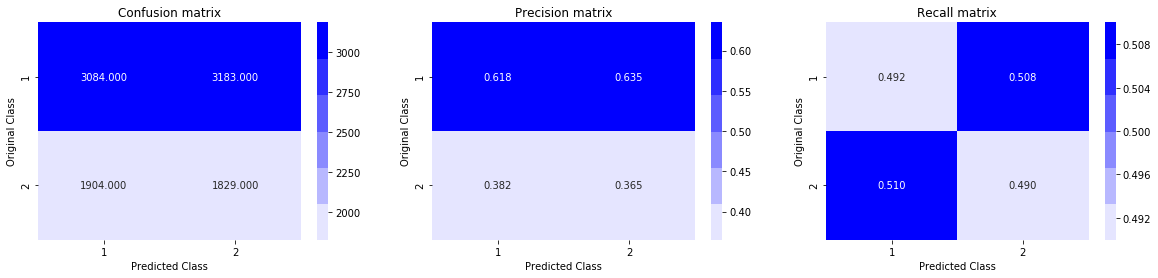

In [15]:
test_len = len(y_test)
train_len = len(y_train)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression with hyper-parameter tuning

For values of alpha =  1e-05 The log loss is: 0.427303052937189
For values of alpha =  0.0001 The log loss is: 0.4146490324907647
For values of alpha =  0.001 The log loss is: 0.42354989460930553
For values of alpha =  0.01 The log loss is: 0.4376423906863354
For values of alpha =  0.1 The log loss is: 0.45904348314400834
For values of alpha =  1 The log loss is: 0.4906774962637248
For values of alpha =  10 The log loss is: 0.5459613692305979


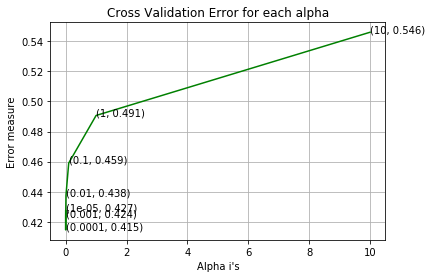

For values of best alpha =  0.0001 The train log loss is: 0.4127349578718349
For values of best alpha =  0.0001 The test log loss is: 0.4146490324907647
Total number of data points : 10000


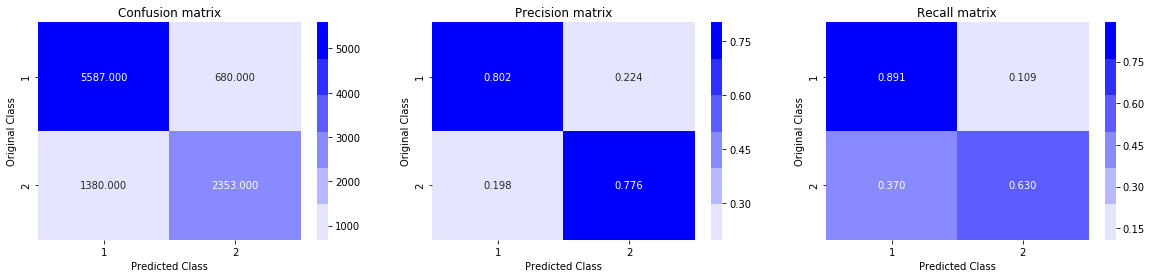

In [16]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**The loss values for Tfidf vectorized data is much less than Tfidf Word2Vec loss values for Logistic Regression. Which means this model did lot better than the model in original notebook**

### Linear-SVM with hyper-parameter tuning

For values of alpha =  1e-05 The log loss is: 0.42085570185631943
For values of alpha =  0.0001 The log loss is: 0.44496904081309385
For values of alpha =  0.001 The log loss is: 0.4756987604337793
For values of alpha =  0.01 The log loss is: 0.5171187047471906
For values of alpha =  0.1 The log loss is: 0.47957363952464294
For values of alpha =  1 The log loss is: 0.573956591705653
For values of alpha =  10 The log loss is: 0.5969699647626083


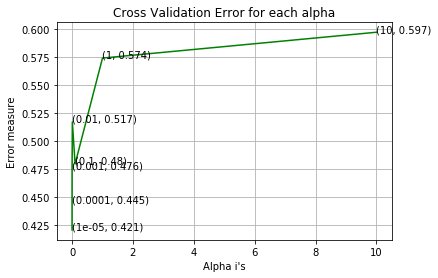

For values of best alpha =  1e-05 The train log loss is: 0.4154266037600815
For values of best alpha =  1e-05 The test log loss is: 0.42085570185631943
Total number of data points : 10000


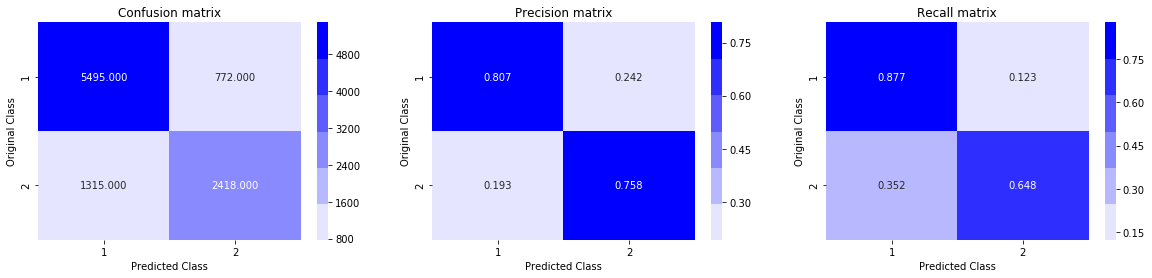

In [17]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Here also we can see that our model improved with Tfidf vectorization in Linear-SVM. and also we can observe in both Logistic Regression and Linear-SVM that they are not overfitted as the train loss and test loss are almost equal**

## Task 2

### Do hyper-parameter tuning on XGBoost model with Tfidf Word2Vec data
**Vectorizing the data to Tfidf Word2Vec again as the models in original notebooks have data leakage**

In [0]:
import spacy
from tqdm import tqdm

In [0]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf.fit_transform(quest_to_vectorize) # these questions are only taken from train data

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

def tfidf_w2v_transform(data):
  vecs = []
  # https://github.com/noamraph/tqdm
  # tqdm is used to print the progress bar
  for qu in tqdm(list(data)):
      doc = nlp(qu)
      # 384 is the number of dimensions of vectors 
      mean_vec = np.zeros([len(doc), len(doc[0].vector)])
      for word in doc:
          # word2vec
          vec = word.vector
          # fetch df score
          try:
              idf = word2tfidf[str(word)]
          except:
              idf = 0
          # compute final vec
          mean_vec += vec * idf
      mean_vec = mean_vec.mean(axis=0)
      vecs.append(mean_vec)
  return list(vecs)

In [21]:
q1_w2v_train = tfidf_w2v_transform(q_train['question1'].values)
q2_w2v_train = tfidf_w2v_transform(q_train['question2'].values)
q1_w2v_test = tfidf_w2v_transform(q_test['question1'].values)
q2_w2v_test = tfidf_w2v_transform(q_test['question2'].values)

100%|██████████| 10000/10000 [01:44<00:00, 95.29it/s]


In [22]:
X_w2v_train = hstack((feat_engg_train, nlp_feats_train, q1_w2v_train, q2_w2v_train)).tocsr()
X_w2v_test = hstack((feat_engg_test, nlp_feats_test, q1_w2v_test, q2_w2v_test)).tocsr()

print(X_w2v_train.shape, y_train.shape)
print(X_w2v_test.shape, y_test.shape)

(40000, 218) (40000, 1)
(10000, 218) (10000, 1)


**The scapy nlp function gives a vector of 96 dimention for a word. So the dimentions are not as same as the dimentions in original notebook**

In [23]:
len(nlp('Hello').vector)

96

### XGBoost with hyper-parameter tuning

In [24]:
import xgboost as xgb

d_train = xgb.DMatrix(X_w2v_train, label=y_train)
d_test = xgb.DMatrix(X_w2v_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

train_result = []
test_result = []

etas = [0.02, 0.05, 0.1, 0.2, 0.3]
depths = [4, 6, 8] # Taking limited range for XGBoost as it only requires underfitted base tree models

for eta in etas:
  train_sub_res = []
  test_sub_res = []
  for dep in depths:
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = eta
    params['max_depth'] = dep


    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=False)
    
    xgdmat = xgb.DMatrix(X_w2v_train, y_train)
    
    predict_y = bst.predict(d_train)
    train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
    train_sub_res.append(train_loss)
    
    predict_y = bst.predict(d_test)
    test_loss = log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15)
    test_sub_res.append(test_loss)
    
    print(f"eta = {eta} and max_depth = {dep}: train loss = {train_loss} and test loss = {test_loss}")
  train_result.append(train_sub_res)
  test_result.append(test_sub_res)
  
print(train_result)
print(test_result)

eta = 0.02 and max_depth = 4: train loss = 0.3456527848904836 and test loss = 0.3577745778926357
eta = 0.02 and max_depth = 6: train loss = 0.29704844136157044 and test loss = 0.34710550052327455
eta = 0.02 and max_depth = 8: train loss = 0.22904690350333987 and test loss = 0.3421931875396171
eta = 0.05 and max_depth = 4: train loss = 0.3022930904685154 and test loss = 0.3440072519325324
eta = 0.05 and max_depth = 6: train loss = 0.21471708702347642 and test loss = 0.3403729557209994
eta = 0.05 and max_depth = 8: train loss = 0.15272361931330034 and test loss = 0.33879815431861715
eta = 0.1 and max_depth = 4: train loss = 0.2542708137487427 and test loss = 0.33837324280897146
eta = 0.1 and max_depth = 6: train loss = 0.18800298595766268 and test loss = 0.33983867158069025
eta = 0.1 and max_depth = 8: train loss = 0.13884129914616386 and test loss = 0.3425457215739836
eta = 0.2 and max_depth = 4: train loss = 0.2642600291833135 and test loss = 0.34380304653407545
eta = 0.2 and max_depth

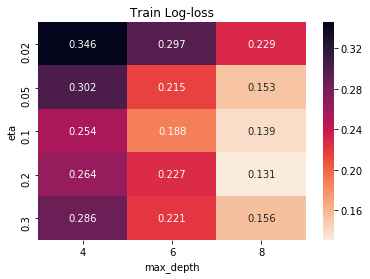

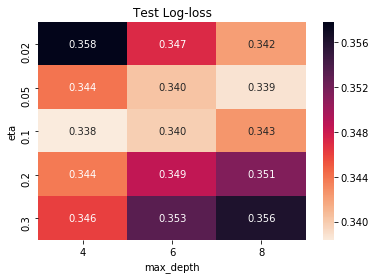

In [30]:
sns.heatmap(train_result, annot=True, fmt='.3f', xticklabels=depths, yticklabels=etas,  cmap=sns.cm.rocket_r)
plt.title('Train Log-loss')
plt.xlabel('max_depth')
plt.ylabel('eta')
plt.show()

sns.heatmap(test_result, annot=True, fmt='.3f', xticklabels=depths, yticklabels=etas,  cmap=sns.cm.rocket_r)
plt.title('Test Log-loss')
plt.xlabel('max_depth')
plt.ylabel('eta')
plt.show()

**All the models are overfitting except with parameters max_depth=4 and eta=0.02, 0.05. As we saw performance of eta=0.02 and depth=4 in original notebook, I am going to train and show results for eta=0.05 and depth=4**

In [31]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.05
params['max_depth'] = 4

# dtrain and watchlist is defined in above code blocks
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.672729	valid-logloss:0.672858
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.53703	valid-logloss:0.537403
[20]	train-logloss:0.469865	valid-logloss:0.470636
[30]	train-logloss:0.432191	valid-logloss:0.433207
[40]	train-logloss:0.409219	valid-logloss:0.410467
[50]	train-logloss:0.394428	valid-logloss:0.396104
[60]	train-logloss:0.384739	valid-logloss:0.38692
[70]	train-logloss:0.377629	valid-logloss:0.380617
[80]	train-logloss:0.372184	valid-logloss:0.376053
[90]	train-logloss:0.368042	valid-logloss:0.372772
[100]	train-logloss:0.364294	valid-logloss:0.369606
[110]	train-logloss:0.360393	valid-logloss:0.366693
[120]	train-logloss:0.356797	valid-logloss:0.364178
[130]	train-logloss:0.353702	valid-logloss:0.362361
[140]	train-logloss:0.350662	valid-logloss:0.360611
[150]	train-logloss:0.347745	valid-logloss:0.358858
[160]	train-logloss:0.345049	v

Total number of data points : 10000


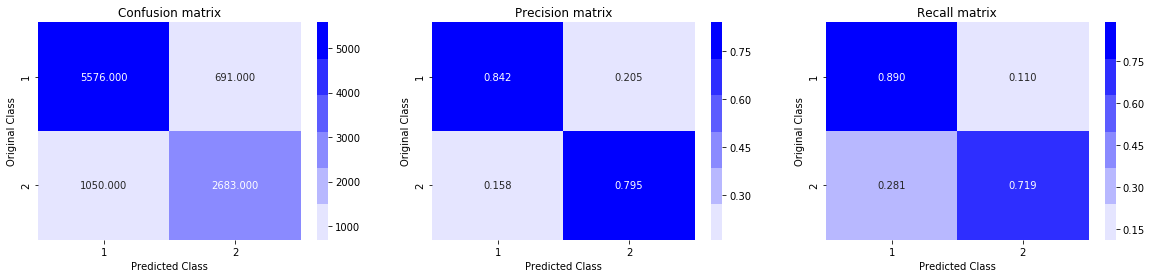

In [32]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Conclusion

- **Linear Regression and Linear-SVM models did very good with Tfidf vectorized data. And XGBoost model did slighty better with hyper-parameter tuning, as the selected hyper-parameters in original notebook are near to optimal ones.**
- **XGBoost has lot of overfitting even when our max_depth is low. Until now the XGBoost model gave good performance compared to other models we tried.**
- **The reason for good performance of Linear models with Tfidf Vectorization is due to high dimentionality.**